# Dog Breed Prediction with Convolutional Neural Networks


Note: This notebook has been repurposed from a project I completed as part of my Udacity Machine Learning Nanodegree. The original project is avaiable [here](https://github.com/jeremyjordan/machine-learning/tree/master/projects/dog-project) and contains additional content (ie. Q&A throughout the notebook) that was part of the course. This notebook presents a more streamlined, cohesive view for those interested in how to build a CNN for image recognition. 

Before you dive in, I recommend you read my [blog post](https://www.jeremyjordan.me/convolutional-neural-networks/) on convolutional neural networks to gain an understanding for what's going on under the hood. 


### Table of Contents

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write the Algorithm
* [Step 6](#step6): Test the Algorithm

---

<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
dog_breeds = len(dog_names)

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

First, we'll develop a method that is capable of detecting the presence of humans in a given photo. For building a true dog breed classifier, this step isn't really necessary, but we'll have some fun with our CNN model and use it to predict what type of dog breed a human _**would**_ be if they were a dog. 

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


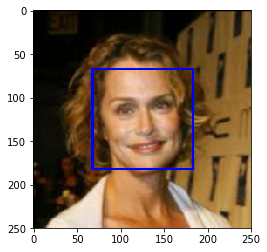

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

Let's evaluate our human face detector on a subset of our image collections for humans and dogs. Ideally, the detector would report human faces in 100% of the human photos and 0% of the dog photos. 

In [20]:
# Select subset of data for faster evaluation
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Vectorize the face dectector function
faces_vfunc = np.vectorize(face_detector)

# Detect faces in both sets
human_faces = faces_vfunc(human_files_short)
dog_faces = faces_vfunc(dog_files_short)

# Calculate and print percentage of faces in each set
print('Faces detected in {:.2f}% of the sample human dataset.'.format((sum(human_faces)/len(human_faces))*100))
print('Faces detected in {:.2f}% of the sample dog dataset.'.format((sum(dog_faces)/len(dog_faces))*100))


Faces detected in 98.00% of the sample human dataset.
Faces detected in 11.00% of the sample dog dataset.


As you can see, the face detector isn't perfect as it finds human faces in 11% of the dog photos. 

Further, the technique we selected for face detection requires a clear view of a face (ie. doesn't perform well on occlusions). If we wanted better performance for a wider variety of photo conditions, we could build a CNN specifically for detecting human faces. The training data should include a diverse set of images from a wide variety of angles, lighting conditions, and partial obscurations (wearing a hat, hand in front of face, etc).

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [5]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

img_width, img_height = 224, 224

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [7]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

Let's evaluate our human face detector on a subset of our image collections for humans and dogs. Ideally, the detector would report human faces in 100% of the human photos and 0% of the dog photos. 

In [25]:
# Files already loaded in previous cell 

# Vectorize the face dectector function
dog_vfunc = np.vectorize(dog_detector)

# Detect dogs in both sets
human_dogs = dog_vfunc(human_files_short)
dog_dogs = dog_vfunc(dog_files_short)

# Calculate and print percentage of faces in each set
print('Dogs detected in {:.2f}% of the sample human dataset.'.format((sum(human_dogs)/len(human_dogs))*100))
print('Dogs detected in {:.2f}% of the sample dog dataset.'.format((sum(dog_dogs)/len(dog_dogs))*100))

Dogs detected in 1.00% of the sample human dataset.
Dogs detected in 100.00% of the sample dog dataset.


As you can see, the dog detector performs better than the human face detector, only detecting dogs in 1% of the human photos. 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  We'll create a CNN _from scratch_ (no transfer learning _yet_!).  In the next section we will use transfer learning to create a CNN that attains greatly improved accuracy.

It's worth mentioning that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  A vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Also, random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [26]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:16<00:00, 50.67it/s]


### Model Architecture

I decided to opt for the standard basic CNN structure for image recognition, a series of convolutional layers with periodic spatial reduction via pooling with a fully connected layer bridging the information learning during convolutions and the final output predictions. I also added dropout to prevent overfitting. My first architecture worked fairly well so I didn't have to do much adjustment. 


In [27]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5), strides = (2,2), padding = 'valid', activation = 'relu', 
          input_shape = (img_width, img_height, 3))) #RGB image
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = (4,4), padding = 'valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid'))
model.add(Conv2D(filters = 64, kernel_size = (2,2), strides = (2,2), padding = 'valid', activation = 'relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(dog_breeds, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 110, 110, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          8256      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               13000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
__________

### Compile the Model

In [28]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train the model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

In [29]:
from keras.callbacks import ModelCheckpoint  

epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.load_weights('saved_models/weights.best.from_scratch.hdf5')

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 83s - loss: 3.7592 - acc: 0.1147 - val_loss: 4.0724 - val_acc: 0.0659
Epoch 2/5
6680/6680 [==============================] - 84s - loss: 3.7068 - acc: 0.1156 - val_loss: 4.0883 - val_acc: 0.0778
Epoch 3/5
6680/6680 [==============================] - 85s - loss: 3.6842 - acc: 0.1232 - val_loss: 4.0971 - val_acc: 0.0671
Epoch 4/5
6680/6680 [==============================] - 87s - loss: 3.6464 - acc: 0.1287 - val_loss: 4.1204 - val_acc: 0.0874
Epoch 5/5
6680/6680 [==============================] - 84s - loss: 3.6112 - acc: 0.1433 - val_loss: 4.0183 - val_acc: 0.0874


### Load the Model with the Best Validation Loss

In [30]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Evaluate the model on the test dataset of dog images.

In [31]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 10.1675%


Already, this network performs significantly better than random chance. However, we can supercharge this network by leveraging transfer learning to start with convolutional layers which have been pre-trained for object recognition in natural photos. 

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

Previously, we built a CNN to learn how to predict dog breeds from scratch. Now, we'll use transfer learning to save on training time and reach much higher accuracy in roughly the same amount of training time. 

In transfer learning, you essentially copy the CNN architecture of a state-of-the-art model, and then perform additional training to learn from your provided dataset. Remember, training is simply finding the best parameters for our model. In convolutional networks, these parameters represent filters which can create feature mappings of your original input. Early layers in the network learn to identify general shapes and patterns in the image, whereas later layers look for more specific features within your image. We can leverage these pretrained filters from existing models rather than spending multiple hours training on a GPU every time we want to build a CNN for object recognition. 

Often, during training we'll freeze the early layers of the convolutional network and only train the parameters for the filters in the last couple of layers (which represent very specific features/attributes of an image). In more extreme cases, we'll freeze all of the convolutional layers and only train the parameters for the fully connected layers that follow. For this project, we'll do just that. 

A convolutional network architecture commonly consists of a series of convolutional and pooling layers, followed by fully connected layers that figure out how to combine the extracted feature mappings to make a classification decision. For the following architecture that we'll build to recognize dog breeds, I'll keep the convolutional architecture of Google's InceptionV3 network and train a new "top model" (the portion of the network that contains fully connected layers at the end of the network). 

To save on computational time, you can download the bottleneck features for our training, validation, and test datasets. These bottleneck features are essentially the output of of the last convolutional layer of the InceptionV3 network, and can be fed directly into our top model. 


The bottleneck features for InceptionV3 is available [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz).

After downloading, store the file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

Extract the bottleneck features corresponding to the train, test, and validation sets.

In [9]:
import numpy as np
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [41]:
train_InceptionV3.shape[1:]

(5, 5, 2048)

### Model Architecture

First, I used a GlobalAveragePooling layer to flatten the features into a vector that could be fed into a fully-connected layer. I was also experiencing some overfitting even with dropout, so I decided to regularize the dense layer's weights. Lastly, the softmax layer predicts the probability of each breed. 

In [10]:
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
inception_model.add(Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
inception_model.add(Dropout(0.4))
inception_model.add(Dense(dog_breeds, activation='softmax'))

inception_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               307350    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               20083     
Total params: 327,433.0
Trainable params: 327,433.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [11]:
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Train the model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss. 

In [44]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

inception_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 7s - loss: 3.0961 - acc: 0.4948 - val_loss: 1.4937 - val_acc: 0.7677
Epoch 2/20
6680/6680 [==============================] - 4s - loss: 1.6687 - acc: 0.7175 - val_loss: 1.2158 - val_acc: 0.7916
Epoch 3/20
6680/6680 [==============================] - 3s - loss: 1.3975 - acc: 0.7421 - val_loss: 1.0835 - val_acc: 0.8084
Epoch 4/20
6680/6680 [==============================] - 3s - loss: 1.2828 - acc: 0.7528 - val_loss: 1.0622 - val_acc: 0.8072
Epoch 5/20
6680/6680 [==============================] - 3s - loss: 1.1955 - acc: 0.7635 - val_loss: 1.0254 - val_acc: 0.8096
Epoch 6/20
6680/6680 [==============================] - 3s - loss: 1.1525 - acc: 0.7690 - val_loss: 1.0272 - val_acc: 0.7916
Epoch 7/20
6680/6680 [==============================] - 3s - loss: 1.1397 - acc: 0.7728 - val_loss: 1.0601 - val_acc: 0.8060
Epoch 8/20
6680/6680 [==============================] - 3s - loss: 1.1392 - ac

### Load the Model with the Best Validation Loss

In [12]:
inception_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### Test the Model

Evaluate the model on the test dataset of dog images.

In [13]:
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.1866%


###  Predict Dog Breed with the Model

Now, we'll write an algorithm to accept an image path as input, obtain the bottleneck features, and classify the dog breed using our CNN. 

In [2]:
def extract_InceptionV3(tensor):
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [14]:
# top_N defines how many predictions to return
top_N = 4

def predict_breed(path):
    
    # load image using path_to_tensor
    print('Loading image...')
    image_tensor = path_to_tensor(path)
    
    # obtain bottleneck features using extract_InceptionV3
    print('Extracting bottleneck features...')
    bottleneck_features = extract_InceptionV3(image_tensor)
    
    # feed into top_model for breed prediction
    print('Feeding bottlenneck features into top model...')
    prediction = inception_model.predict(bottleneck_features)[0]
    
    # sort predicted breeds by highest probability, extract the top N predictions
    breeds_predicted = [dog_names[idx] for idx in np.argsort(prediction)[::-1][:top_N]]
    confidence_predicted = np.sort(prediction)[::-1][:top_N]
    
    print('Predicting breed...')
    # take prediction, lookup in dog_names, return value
    return breeds_predicted, confidence_predicted
    

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Now, we'll write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

![Sample Human Output](images/sample_human_output.png)


In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def make_prediction(path, multiple_breeds = False):
    breeds, confidence = predict_breed(path)
    img = mpimg.imread(path)
    plt.axis('off')
    
    # since the dog detector worked better, and we don't have 
    # access to softmax probabilities from dog and face detectors
    # we'll first check for dog detection, and only if there are no dogs
    # detected we'll check for humans
    if dog_detector(path):
        print('Woof woof!')
        imgplot = plt.imshow(img)
        print('You look like a {}.'.format(breeds[0].replace("_", " ")))
        
        if multiple_breeds:
            print('\n\nTop 4 predictions (for mixed breeds)')
            for i, j in zip(breeds, confidence):
                print('Predicted breed: {} with a confidence of {:.4f}'.format(i.replace("_", " "), j))
        
    elif face_detector(path):
        print('Hello human!')
        imgplot = plt.imshow(img)
        print('If you were a dog, you\'d be a {}.'.format(breeds[0].replace("_", " ")))
    else:
        raise ValueError('Could not detect dogs or humans in image.')
        

---
<a id='step6'></a>
## Step 6: Test the Algorithm on Real World Data

I let my Facebook friends post photos of their dogs and ran the photo through my breed classifier to evaluate its performance on real-world data. While it doesn't meet the accuracy reported by the test set evaluation (my friends posted dog breeds that weren't in the training data), it was still very interesting to see what the CNN would predict. 

Also, as far as predicting the dog breed that a human most closely resembles, it might be advantageous to only feed in the bounding box of the face in the photo. Since the ConvNet was not trained to detect humans, we want to decrease the likelihood that it accidentally learns from other features in the photo (such as the pattern on someone's shirt).

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Hello human!
If you were a dog, you'd be a Glen of imaal terrier.


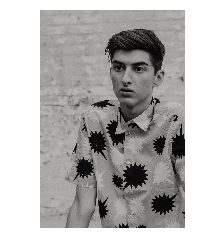

In [58]:
make_prediction('images/EvanSmithBW-4.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Lowchen.


Top 4 predictions (for mixed breeds)
Predicted breed: Lowchen with a confidence of 0.9216
Predicted breed: Havanese with a confidence of 0.0568
Predicted breed: Lhasa apso with a confidence of 0.0177
Predicted breed: Petit basset griffon vendeen with a confidence of 0.0014


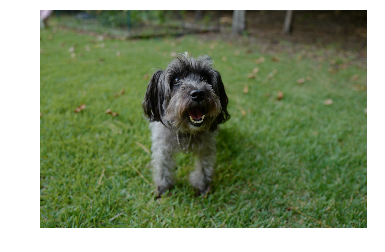

In [85]:
make_prediction('images/Molly-Schnoodle.JPG', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Golden retriever.


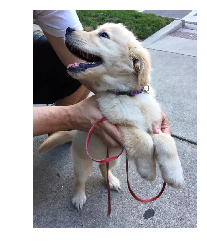

In [60]:
make_prediction('images/dog_spotting1.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Norwegian lundehund.


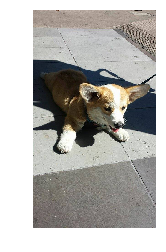

In [61]:
make_prediction('images/dog_spotting2.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Icelandic sheepdog.


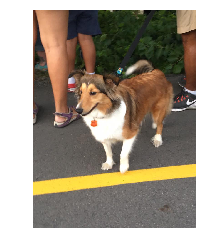

In [62]:
make_prediction('images/dog_spotting3.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Hello human!
If you were a dog, you'd be a Dachshund.


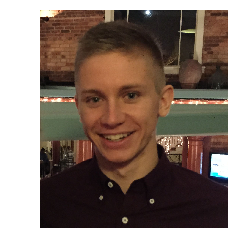

In [63]:
make_prediction('images/headshot.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Portuguese water dog.


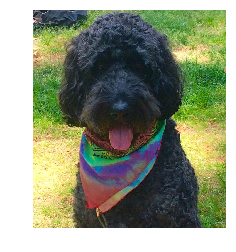

In [65]:
make_prediction('images/amber.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...


ValueError: Could not detect dogs or humans in image.

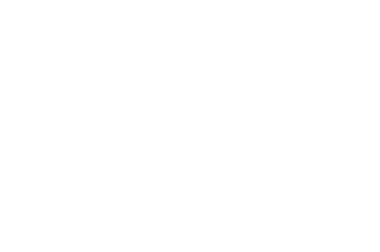

In [66]:
make_prediction('images/hot-diggity-dog.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Petit basset griffon vendeen.
Top 4 predictions (for mixed breeds)
Predicted breed: Petit basset griffon vendeen with a confidence of 0.6817
Predicted breed: Portuguese water dog with a confidence of 0.0998
Predicted breed: Chinese crested with a confidence of 0.0412
Predicted breed: Basenji with a confidence of 0.0369


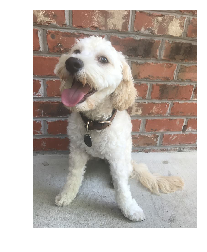

In [81]:
make_prediction('images/mary.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a American staffordshire terrier.


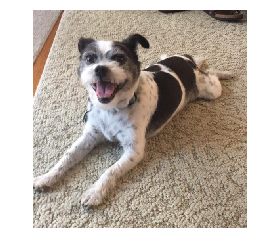

In [71]:
make_prediction('images/carmen.png')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Basenji.


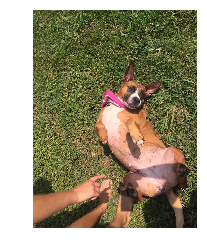

In [72]:
make_prediction('images/jason.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Norwegian lundehund.


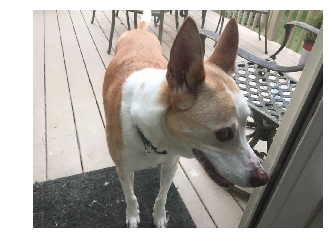

In [73]:
make_prediction('images/jason2.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Maltese.


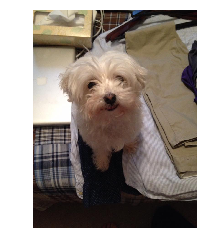

In [74]:
make_prediction('images/will.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Labrador retriever.


Top 4 predictions (for mixed breeds)
Predicted breed: Labrador retriever with a confidence of 0.9462
Predicted breed: Golden retriever with a confidence of 0.0350
Predicted breed: Nova scotia duck tolling retriever with a confidence of 0.0078
Predicted breed: Anatolian shepherd dog with a confidence of 0.0042


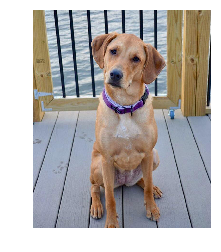

In [87]:
make_prediction('images/chelsea.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Anatolian shepherd dog.


Top 4 predictions (for mixed breeds)
Predicted breed: Anatolian shepherd dog with a confidence of 0.3509
Predicted breed: Plott with a confidence of 0.1281
Predicted breed: German pinscher with a confidence of 0.1023
Predicted breed: Dogue de bordeaux with a confidence of 0.0957


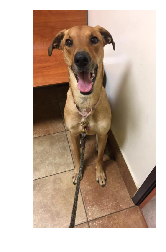

In [86]:
make_prediction('images/kendall.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Parson russell terrier.


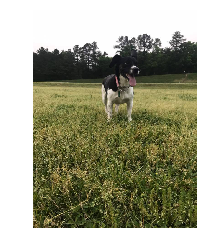

In [77]:
make_prediction('images/andii.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Manchester terrier.


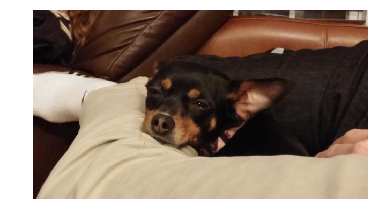

In [79]:
make_prediction('images/chase.jpeg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...


ValueError: Could not detect dogs or humans in image.

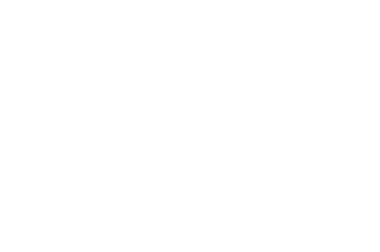

In [80]:
make_prediction('images/zoinks.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Bichon frise.


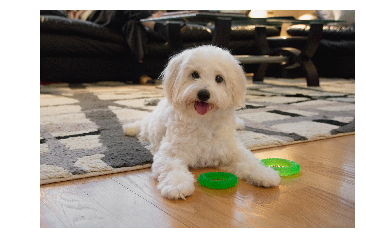

In [81]:
make_prediction('images/jimmy.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Pomeranian.


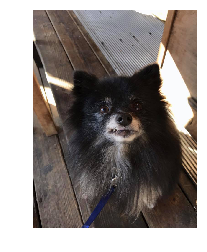

In [82]:
make_prediction('images/megan.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Nova scotia duck tolling retriever.


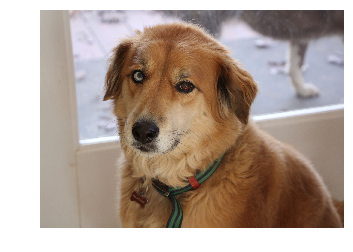

In [83]:
make_prediction('images/tea1.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Nova scotia duck tolling retriever.


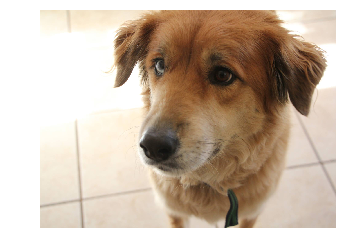

In [84]:
make_prediction('images/tea2.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Norwegian lundehund.


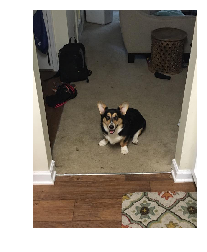

In [85]:
make_prediction('images/thomas.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Portuguese water dog.


Top 4 predictions (for mixed breeds)
Predicted breed: Portuguese water dog with a confidence of 0.9819
Predicted breed: Irish water spaniel with a confidence of 0.0064
Predicted breed: Wirehaired pointing griffon with a confidence of 0.0022
Predicted breed: Poodle with a confidence of 0.0022


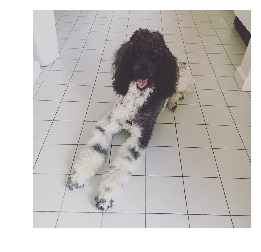

In [88]:
make_prediction('images/jordan.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Labrador retriever.


Top 4 predictions (for mixed breeds)
Predicted breed: Labrador retriever with a confidence of 0.3903
Predicted breed: Cairn terrier with a confidence of 0.1689
Predicted breed: Cane corso with a confidence of 0.1206
Predicted breed: Plott with a confidence of 0.0729


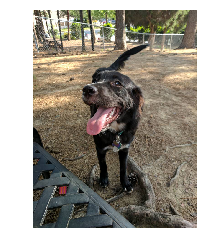

In [89]:
make_prediction('images/jessie1.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Portuguese water dog.


Top 4 predictions (for mixed breeds)
Predicted breed: Portuguese water dog with a confidence of 0.6436
Predicted breed: Lakeland terrier with a confidence of 0.1694
Predicted breed: Kerry blue terrier with a confidence of 0.0532
Predicted breed: American water spaniel with a confidence of 0.0396


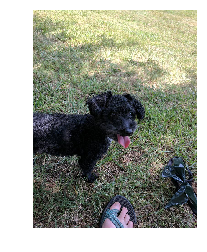

In [90]:
make_prediction('images/jessie2.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Flat-coated retriever.


Top 4 predictions (for mixed breeds)
Predicted breed: Flat-coated retriever with a confidence of 0.4988
Predicted breed: Labrador retriever with a confidence of 0.4839
Predicted breed: Greyhound with a confidence of 0.0050
Predicted breed: Newfoundland with a confidence of 0.0031


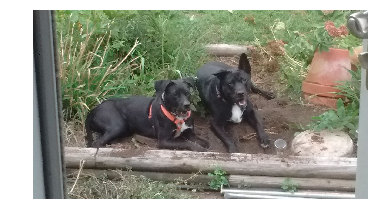

In [91]:
make_prediction('images/george.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Beauceron.


Top 4 predictions (for mixed breeds)
Predicted breed: Beauceron with a confidence of 0.2818
Predicted breed: Airedale terrier with a confidence of 0.2697
Predicted breed: Australian cattle dog with a confidence of 0.1548
Predicted breed: Australian shepherd with a confidence of 0.0476


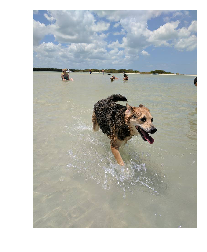

In [92]:
make_prediction('images/jessie3.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a American staffordshire terrier.


Top 4 predictions (for mixed breeds)
Predicted breed: American staffordshire terrier with a confidence of 0.6332
Predicted breed: Cane corso with a confidence of 0.3428
Predicted breed: Boxer with a confidence of 0.0084
Predicted breed: Chinese shar-pei with a confidence of 0.0039


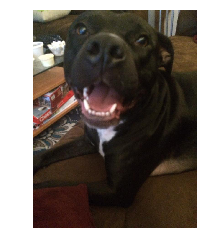

In [93]:
make_prediction('images/jenny.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Anatolian shepherd dog.


Top 4 predictions (for mixed breeds)
Predicted breed: Anatolian shepherd dog with a confidence of 0.2961
Predicted breed: Pointer with a confidence of 0.2753
Predicted breed: Great dane with a confidence of 0.2406
Predicted breed: Labrador retriever with a confidence of 0.0639


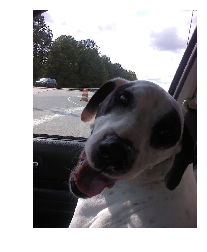

In [94]:
make_prediction('images/ally.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Parson russell terrier.


Top 4 predictions (for mixed breeds)
Predicted breed: Parson russell terrier with a confidence of 0.9378
Predicted breed: Smooth fox terrier with a confidence of 0.0129
Predicted breed: Irish terrier with a confidence of 0.0107
Predicted breed: Chinese shar-pei with a confidence of 0.0095


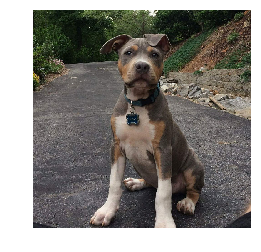

In [95]:
make_prediction('images/lane.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Akita.


Top 4 predictions (for mixed breeds)
Predicted breed: Akita with a confidence of 0.4406
Predicted breed: Norwegian buhund with a confidence of 0.1765
Predicted breed: Icelandic sheepdog with a confidence of 0.1410
Predicted breed: Boxer with a confidence of 0.0970


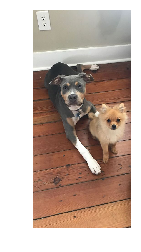

In [96]:
make_prediction('images/lane2.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Finnish spitz.


Top 4 predictions (for mixed breeds)
Predicted breed: Finnish spitz with a confidence of 0.3524
Predicted breed: Akita with a confidence of 0.2076
Predicted breed: Cairn terrier with a confidence of 0.1674
Predicted breed: Canaan dog with a confidence of 0.1215


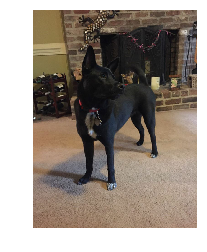

In [97]:
make_prediction('images/hannah.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Dachshund.


Top 4 predictions (for mixed breeds)
Predicted breed: Dachshund with a confidence of 0.9012
Predicted breed: German pinscher with a confidence of 0.0764
Predicted breed: Manchester terrier with a confidence of 0.0075
Predicted breed: Plott with a confidence of 0.0058


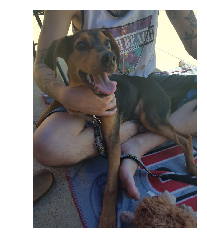

In [99]:
make_prediction('images/meganh.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Beauceron.


Top 4 predictions (for mixed breeds)
Predicted breed: Beauceron with a confidence of 0.8684
Predicted breed: Dachshund with a confidence of 0.1001
Predicted breed: Doberman pinscher with a confidence of 0.0194
Predicted breed: German pinscher with a confidence of 0.0035


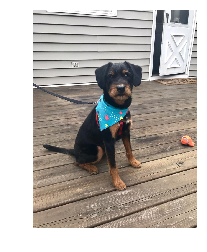

In [100]:
make_prediction('images/logan.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...


ValueError: Could not detect dogs or humans in image.

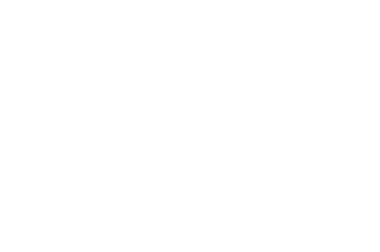

In [101]:
make_prediction('images/snoop.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Dogue de bordeaux.


Top 4 predictions (for mixed breeds)
Predicted breed: Dogue de bordeaux with a confidence of 0.9620
Predicted breed: Labrador retriever with a confidence of 0.0152
Predicted breed: Nova scotia duck tolling retriever with a confidence of 0.0100
Predicted breed: Plott with a confidence of 0.0048


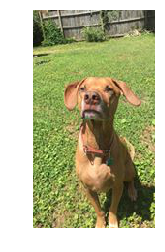

In [102]:
make_prediction('images/alina.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Cairn terrier.


Top 4 predictions (for mixed breeds)
Predicted breed: Cairn terrier with a confidence of 0.9514
Predicted breed: Icelandic sheepdog with a confidence of 0.0118
Predicted breed: Lhasa apso with a confidence of 0.0103
Predicted breed: Norwegian buhund with a confidence of 0.0047


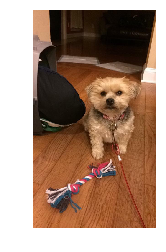

In [103]:
make_prediction('images/melissa1.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Cairn terrier.


Top 4 predictions (for mixed breeds)
Predicted breed: Cairn terrier with a confidence of 0.9554
Predicted breed: Icelandic sheepdog with a confidence of 0.0259
Predicted breed: Finnish spitz with a confidence of 0.0045
Predicted breed: Norfolk terrier with a confidence of 0.0032


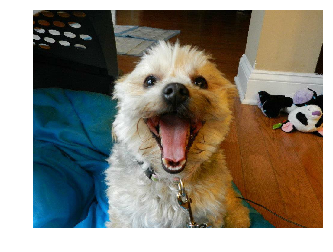

In [104]:
make_prediction('images/melissa2.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...


ValueError: Could not detect dogs or humans in image.

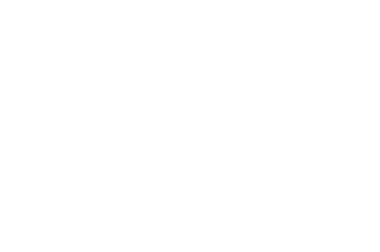

In [105]:
make_prediction('images/taylor.jpg')

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Lhasa apso.


Top 4 predictions (for mixed breeds)
Predicted breed: Lhasa apso with a confidence of 0.6122
Predicted breed: Lowchen with a confidence of 0.2190
Predicted breed: Havanese with a confidence of 0.1025
Predicted breed: Icelandic sheepdog with a confidence of 0.0198


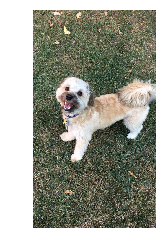

In [31]:
make_prediction('images/akash.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a American foxhound.


Top 4 predictions (for mixed breeds)
Predicted breed: American foxhound with a confidence of 0.8576
Predicted breed: Beagle with a confidence of 0.1422
Predicted breed: Dachshund with a confidence of 0.0001
Predicted breed: Plott with a confidence of 0.0000


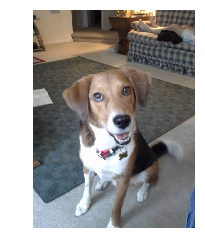

In [32]:
make_prediction('images/caleb.jpg', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Nova scotia duck tolling retriever.


Top 4 predictions (for mixed breeds)
Predicted breed: Nova scotia duck tolling retriever with a confidence of 0.5648
Predicted breed: Leonberger with a confidence of 0.1677
Predicted breed: Golden retriever with a confidence of 0.1511
Predicted breed: Anatolian shepherd dog with a confidence of 0.0643


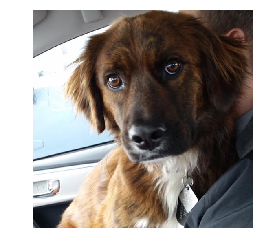

In [33]:
make_prediction('images/taylor.png', multiple_breeds = True)

Loading image...
Extracting bottleneck features...
Feeding bottlenneck features into top model...
Predicting breed...
Woof woof!
You look like a Chihuahua.


Top 4 predictions (for mixed breeds)
Predicted breed: Chihuahua with a confidence of 0.4925
Predicted breed: Norwegian buhund with a confidence of 0.2395
Predicted breed: Canaan dog with a confidence of 0.1754
Predicted breed: Cairn terrier with a confidence of 0.0232


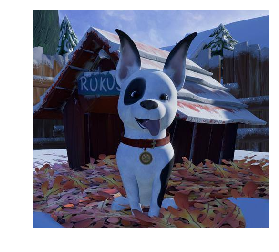

In [21]:
make_prediction('images/primus.png', multiple_breeds = True)